In [1]:
import pandas as pd
import ipwhois
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("IPResults.csv")
df = df.drop([0, 1])

# Reset the index to start from 0
df = df.reset_index(drop=True)

# Function to calculate allowed birth years for the age range
def calculate_allowed_birth_years(age_range):
    # Split the age range by '-'
    if age_range == "75 years or older":
        start_age, end_age = 75, 90
    else:
        start_age, end_age = map(int, age_range.split('-'))

    # Calculate the allowed birth years (assuming the current year is 2023)
    allowed_birth_years = list(range(2023 - end_age, 2023 - start_age + 1))
    
    # Add one less than the smallest allowed birth year
    allowed_birth_years.append(allowed_birth_years[0] - 1)
    allowed_birth_years.append(allowed_birth_years[0] - 1)
    
    return allowed_birth_years

# Function to process JSON data and extract IP prefixes
def process_json(json_filename):
    # Load JSON data from the file
    with open(json_filename, "r") as json_file:
        json_data = json.load(json_file)

    # Initialize a set to store all IP prefixes
    all_ip_prefixes = set()

    # Extract and convert the IP prefixes
    for entry in json_data.get("prefixes", []) + json_data.get("values", []):
        if "ip_prefix" in entry:
            ip_prefix = entry["ip_prefix"].split("/")  # Split the IP prefix to get the network part
            if len(ip_prefix) > 1:
                ip_prefix = ".".join(ip_prefix[0].split(".")[:3])  # Get the first three octets
            all_ip_prefixes.add(ip_prefix)
        elif "properties" in entry and "addressPrefixes" in entry["properties"]:
            address_prefixes = entry["properties"]["addressPrefixes"]
            for prefix in address_prefixes:
                ip_prefix = prefix.split("/")  # Split the IP prefix to get the network part
                if len(ip_prefix) > 1:
                    ip_prefix = ".".join(ip_prefix[0].split(".")[:3])  # Get the first three octets
                all_ip_prefixes.add(ip_prefix)

    return all_ip_prefixes

# Function to check if an IP is in the United States and add 1 to BotRisk if true
def check_ip_in_us(ip, df, index):
    for retry in range(5):
        try:
            obj = ipwhois.IPWhois(ip)
            results = obj.lookup_rdap()
            country = results.get('asn_country_code')
            if country == "US":
                return
        except ipwhois.exceptions.IPDefinedError:
            df.at[index, 'BotRisk'] += 1
            df.at[index, 'NonUSIP'] = True
            return
        except Exception as e:
            if retry == 4:
                df.at[index, 'BotRisk'] += 1
                df.at[index, 'NonUSIP'] = True

def check_coordinates_in_us(latitude, longitude, df, index):
    if not (24.396308 <= float(latitude) <= 49.384358 and -125.000000 <= float(longitude) <= -66.934570):
        df.at[index, 'BotRisk'] += 1
        df.at[index, 'NonUSLongLat'] = True

# Process Amazon JSON data
amazon_ip_prefixes = process_json("amazon-ip-ranges.json")

# Process Google JSON data
google_ip_prefixes = process_json("google-ServiceTags_Public_20230918.json")

# Initialize counters for matches, non-matches, and dictionaries to store them
matches = 0
non_matches = 0
matches_dict = {}
non_matches_dict = {}

# Add a 'BotRisk' column to the DataFrame and initialize it to 0
df['BotRisk'] = 0
df['BirthYearOff'] = False
df['DuplicateIP'] = False
df['DuplicateLongLat'] = False
df['NonUSIP'] = False
df['NonUSLongLat'] = False

# Create a set to store seen IP addresses and first three octets of IP addresses
seen_ips = set()
seen_first_three_octets = set()
seen_coordinates = set()

# Iterate through the DataFrame and calculate allowed birth years
for index, row in df.iterrows():
    age_range = row["Q1"]
    allowed_birth_years = calculate_allowed_birth_years(age_range)
    
    # Store the allowed birth years in the dictionary
    allowed_birth_years_dict = {age_range: allowed_birth_years}
    
    # Check if birth year matches the allowed years for age range
    age_range = row["Q1"]
    birth_year = int(row["Q4"])
    
    allowed_birth_years = allowed_birth_years_dict.get(age_range, [])
    
    if birth_year in allowed_birth_years:
        matches += 1
        matches_dict[index] = f"Birth year ({birth_year}) matches the expected year for age range {age_range}."
    else:
        non_matches += 1
        closest_year = min(allowed_birth_years, key=lambda x: abs(x - birth_year))
        year_difference = abs(birth_year - closest_year)
        non_matches_dict[index] = f"Birth year ({birth_year}) does not match the expected year for age range {age_range}. Off by {year_difference} years."
        
        # Update the 'BotRisk' column to 1 for non-matching rows
        df.at[index, 'BotRisk'] = 1
        df.at[index, 'BirthYearOff'] = True
    

    # Check if the first three octets of the IP address have been seen before
    ip_address = row["IPAddress"]
    first_three_octets = ".".join(ip_address.split(".")[:3])
    if first_three_octets in seen_first_three_octets:
        df.at[index, 'BotRisk'] += 1  # Increment 'BotRisk' for duplicate first three octets
        df.at[index, 'DuplicateIP'] = True
    else:
        seen_first_three_octets.add(first_three_octets)
        
    
    coordinates = (row["LocationLatitude"], row["LocationLongitude"])
    if coordinates in seen_coordinates:
        # df.at[index, 'BotRisk'] += 1  # Increment 'BotRisk' for duplicate coordinates
        df.at[index, 'DuplicateLongLat'] = True
    else:
        seen_coordinates.add(coordinates)

    # Check if the IP is in the United States and add 1 to BotRisk if false
    check_ip_in_us(ip_address, df, index)
    check_coordinates_in_us(row["LocationLatitude"], row["LocationLongitude"], df, index)

# Print the updated DataFrame with the 'BotRisk' column
print(df['BotRisk'])

# # Calculate counts for each factor and combinations
# only_birth_year_off = len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (~df['DuplicateLongLat']) & (~df['NonUSIP'])])
# only_duplicate_ip = len(df[(~df['BirthYearOff']) & (df['DuplicateIP']) & (~df['DuplicateLongLat']) & (~df['NonUSIP'])])
# only_duplicate_long_lat = len(df[(~df['BirthYearOff']) & (~df['DuplicateIP']) & (df['DuplicateLongLat']) & (~df['NonUSIP'])])
# only_non_us_ip = len(df[(~df['BirthYearOff']) & (~df['DuplicateIP']) & (~df['DuplicateLongLat']) & (df['NonUSIP'])])

# # Calculate counts for combinations
# both_birth_year_and_duplicate_ip = len(df[(df['BirthYearOff']) & (df['DuplicateIP']) & (~df['DuplicateLongLat']) & (~df['NonUSIP'])])
# both_birth_year_and_duplicate_long_lat = len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (df['DuplicateLongLat']) & (~df['NonUSIP'])])
# both_birth_year_and_non_us_ip = len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (~df['DuplicateLongLat']) & (df['NonUSIP'])])
# both_duplicate_ip_and_duplicate_long_lat = len(df[(~df['BirthYearOff']) & (df['DuplicateIP']) & (df['DuplicateLongLat']) & (~df['NonUSIP'])])
# both_duplicate_ip_and_non_us_ip = len(df[(~df['BirthYearOff']) & (df['DuplicateIP']) & (~df['DuplicateLongLat']) & (df['NonUSIP'])])
# both_duplicate_long_lat_and_non_us_ip = len(df[(~df['BirthYearOff']) & (~df['DuplicateIP']) & (df['DuplicateLongLat']) & (df['NonUSIP'])])

# # Calculate counts for cases where three factors are true
# three_factors_true_count = len(df[~(df['BirthYearOff']) & (df['DuplicateIP']) & (df['DuplicateLongLat']) & (df['NonUSIP'])]) + len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (df['DuplicateLongLat']) & (df['NonUSIP'])]) + len(df[(df['BirthYearOff']) & (df['DuplicateIP']) & (~df['DuplicateLongLat']) & (df['NonUSIP'])]) + len(df[(df['BirthYearOff']) & (df['DuplicateIP']) & (df['DuplicateLongLat']) & (~df['NonUSIP'])])

# # Calculate counts for cases where all four factors are true
# all_four_factors_true_count = len(df[df['BirthYearOff'] & df['DuplicateIP'] & df['DuplicateLongLat'] & df['NonUSIP']])

# # Print counts for individual factors
# print(f"Only BirthYearOff: {only_birth_year_off}")
# print(f"Only DuplicateIP: {only_duplicate_ip}")
# print(f"Only DuplicateLongLat: {only_duplicate_long_lat}")
# print(f"Only NonUSIP: {only_non_us_ip}")

# # Print counts for combinations
# print(f"Both BirthYearOff and DuplicateIP: {both_birth_year_and_duplicate_ip}")
# print(f"Both BirthYearOff and DuplicateLongLat: {both_birth_year_and_duplicate_long_lat}")
# print(f"Both BirthYearOff and NonUSIP: {both_birth_year_and_non_us_ip}")
# print(f"Both DuplicateIP and DuplicateLongLat: {both_duplicate_ip_and_duplicate_long_lat}")
# print(f"Both DuplicateIP and NonUSIP: {both_duplicate_ip_and_non_us_ip}")
# print(f"Both DuplicateLongLat and NonUSIP: {both_duplicate_long_lat_and_non_us_ip}")

# # Print counts for cases where three factors are true and all four factors are true
# print(f"Three factors are true: {three_factors_true_count}")
# print(f"All four factors are true: {all_four_factors_true_count}")


# Calculate counts for each factor and combinations without 'DuplicateLongLat'
only_birth_year_off = len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (~df['NonUSIP']) & (~df['NonUSLongLat'])])
only_duplicate_ip = len(df[(~df['BirthYearOff']) & (df['DuplicateIP']) & (~df['NonUSIP']) & (~df['NonUSLongLat'])])
only_non_us_ip = len(df[(~df['BirthYearOff']) & (~df['DuplicateIP']) & (df['NonUSIP']) & (~df['NonUSLongLat'])])
only_non_us_long = len(df[(~df['BirthYearOff']) & (~df['DuplicateIP']) & (~df['NonUSIP']) & (df['NonUSLongLat'])])

# Calculate counts for combinations without 'DuplicateLongLat'
both_birth_year_and_duplicate_ip = len(df[(df['BirthYearOff']) & (df['DuplicateIP']) & (~df['NonUSIP']) & (~df['NonUSLongLat'])])
both_birth_year_and_non_us_ip = len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (df['NonUSIP']) & (~df['NonUSLongLat'])])
both_duplicate_ip_and_non_us_ip = len(df[(~df['BirthYearOff']) & (df['DuplicateIP']) & (df['NonUSIP']) & (~df['NonUSLongLat'])])
both_birth_year_and_non_us_long = len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (~df['NonUSIP']) & (df['NonUSLongLat'])])
both_duplicate_ip_and_non_us_long = len(df[(~df['BirthYearOff']) & (df['DuplicateIP']) & (~df['NonUSIP']) & (df['NonUSLongLat'])])
both_non_us_ip_and_non_us_long = len(df[(~df['BirthYearOff']) & (~df['DuplicateIP']) & (df['NonUSIP']) & (df['NonUSLongLat'])])

# Calculate counts for cases where all four factors are true without 'DuplicateLongLat'
three_factors_true_count = len(df[~(df['BirthYearOff']) & (df['DuplicateIP']) & (df['NonUSLongLat']) & (df['NonUSIP'])]) + len(df[(df['BirthYearOff']) & (~df['DuplicateIP']) & (df['DuplicateLongLat']) & (df['NonUSIP'])]) + len(df[(df['BirthYearOff']) & (df['DuplicateIP']) & (~df['NonUSLongLat']) & (df['NonUSIP'])]) + len(df[(df['BirthYearOff']) & (df['DuplicateIP']) & (df['NonUSLongLat']) & (~df['NonUSIP'])])
all_four_factors_true = len(df[df['BirthYearOff'] & df['DuplicateIP'] & df['NonUSIP'] & (df['NonUSLongLat'])])

# Print counts for individual factors

print(f"Total BirthYearOff: {len(df[df['BirthYearOff']])}")
print(f"Total DuplicateIP: {len(df[df['DuplicateIP']])}")
print(f"Total NonUSIP: {len(df[df['NonUSIP']])}")
print(f"Total NonUSLongLat: {len(df[df['NonUSLongLat']])}")

print(f"Only BirthYearOff: {only_birth_year_off}")
print(f"Only DuplicateIP: {only_duplicate_ip}")
print(f"Only NonUSIP: {only_non_us_ip}")
print(f"Only NonUSLongLat: {only_non_us_long}")

# Print counts for combinations
print(f"Both BirthYearOff and DuplicateIP: {both_birth_year_and_duplicate_ip}")
print(f"Both BirthYearOff and NonUSIP: {both_birth_year_and_non_us_ip}")
print(f"Both BirthYearOff and NonUSLongLat: {both_birth_year_and_non_us_long}")
print(f"Both DuplicateIP and NonUSIP: {both_duplicate_ip_and_non_us_ip}")
print(f"Both DuplicateIP and NonUSLongLat: {both_duplicate_ip_and_non_us_long}")
print(f"Both NonUSIP and NonUSLongLat: {both_non_us_ip_and_non_us_long}")

# Print counts for cases where three factors are true
print(f"Three factors are true: {three_factors_true_count}")
print(f"All four factors are true: {all_four_factors_true}")


0      0
1      0
2      0
3      1
4      0
      ..
544    1
545    1
546    1
547    1
548    1
Name: BotRisk, Length: 549, dtype: int64
Total BirthYearOff: 33
Total DuplicateIP: 116
Total NonUSIP: 0
Total NonUSLongLat: 79
Only BirthYearOff: 18
Only DuplicateIP: 94
Only NonUSIP: 0
Only NonUSLongLat: 61
Both BirthYearOff and DuplicateIP: 9
Both BirthYearOff and NonUSIP: 0
Both BirthYearOff and NonUSLongLat: 5
Both DuplicateIP and NonUSIP: 0
Both DuplicateIP and NonUSLongLat: 12
Both NonUSIP and NonUSLongLat: 0
Three factors are true: 1
All four factors are true: 0


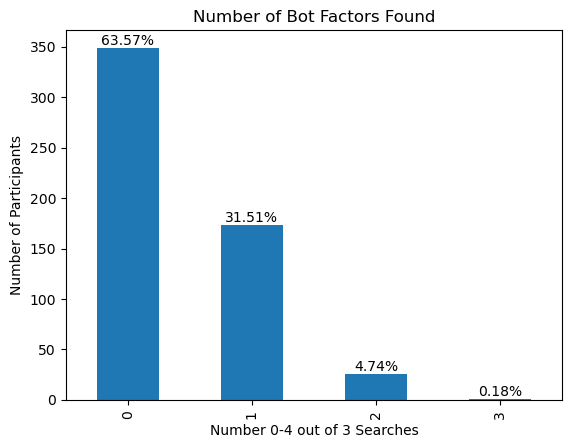

In [2]:
dataToPlot = df.groupby('BotRisk').RandomSurveyID.count()
ax = dataToPlot.plot.bar(rot=90)

plt.ylabel("Number of Participants")
plt.title("Number of Bot Factors Found")
plt.xlabel("Number 0-4 out of 3 Searches")

heightlst = []
for i in ax.patches:
    heightlst.append(i.get_height())
total = sum(heightlst)

for i in ax.patches:
    height = i.get_height()
    value = ("{0:.2f}".format((i.get_height()/total)*100)+'%')
    ax.annotate(value, (i.get_x() + i.get_width()/2, height+0.05), ha='center', va='bottom')

plt.savefig("BotRisk.png", bbox_inches="tight")
plt.show()